In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

## Data Ingestion

In [2]:
df_true  = pd.read_csv('True.csv')
df_fake  = pd.read_csv('Fake.csv')

## Preprocessing

In [3]:
df_true['label'] = 1
df_fake['label'] = 0

In [4]:
df = pd.concat([df_true,df_fake],ignore_index=True)

In [5]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
df.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [7]:
df['label'] = df['label'].astype(int)

In [8]:
df.dropna(inplace=True)

In [9]:
df.drop(['title','subject','date'] ,axis=1, inplace=True)

In [10]:
df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


## Train, Validation & Test Split (80 : 10 : 10)

In [11]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [12]:
len(train), len(val), len(test)

(35918, 4490, 4490)

### Convert Pandas into Tensors

In [13]:
### Convert Pandas into Tensors Function
def df_to_dataset(dataframe, shuffle=True, batch_size=512):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [14]:
## Converting
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Model


## Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. 

An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). 

Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). 

It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

https://www.tensorflow.org/text/guide/word_embeddings#:~:text=An%20embedding%20is%20a%20dense,weights%20for%20a%20dense%20layer).

In [15]:
### Load Embedding from Tensorflow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [16]:
## Check out transformed word embeddings
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 1.3131764 ,  0.07953814, -0.16234626, ..., -0.4159042 ,
        -0.13674702, -0.6442992 ],
       [ 1.3544304 ,  1.0034648 ,  0.47337195, ..., -0.38916913,
        -0.82601964, -0.7188742 ],
       [ 1.1988777 ,  0.52169776, -0.05533645, ..., -0.3359296 ,
        -0.18071195, -0.14942886],
       ...,
       [ 0.5523421 ,  0.8431964 ,  0.23348646, ..., -0.02175691,
        -0.29126716, -0.48622093],
       [ 0.28120315,  0.36527687,  0.10531446, ...,  0.11882182,
        -0.1746906 , -0.23092602],
       [ 0.6359905 ,  0.32561597,  0.29788283, ...,  0.13507915,
        -0.43898144, -0.00224022]], dtype=float32)>

In [17]:
## Building the model using Keras
model1 = tf.keras.Sequential()
model1.add(hub_layer)
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.4))
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.4))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC'])

### Base Line Tests

In [19]:
model1.evaluate(train_data)

71/71 [==============================] - 6s 59ms/step - loss: 0.6923 - accuracy: 0.5191 - auc: 0.5284


[0.6923465132713318, 0.5191268920898438, 0.5284261703491211]

In [20]:
model1.evaluate(valid_data)

9/9 [==============================] - 1s 75ms/step - loss: 0.6913 - accuracy: 0.5216 - auc: 0.5322


[0.6913354396820068, 0.5216035842895508, 0.5321739315986633]

## Train Fake News Model with history

In [21]:
history1 = model1.fit(train_data, epochs=30, validation_data=valid_data)

Epoch 1/30
71/71 [==============================] - 8s 94ms/step - loss: 0.5131 - accuracy: 0.7691 - auc: 0.8586 - val_loss: 0.2217 - val_accuracy: 0.9575 - val_auc: 0.9893
Epoch 2/30
71/71 [==============================] - 7s 100ms/step - loss: 0.1954 - accuracy: 0.9493 - auc: 0.9839 - val_loss: 0.0591 - val_accuracy: 0.9862 - val_auc: 0.9981
Epoch 3/30
71/71 [==============================] - 7s 97ms/step - loss: 0.0861 - accuracy: 0.9827 - auc: 0.9964 - val_loss: 0.0290 - val_accuracy: 0.9918 - val_auc: 0.9993
Epoch 4/30
71/71 [==============================] - 8s 105ms/step - loss: 0.0430 - accuracy: 0.9920 - auc: 0.9988 - val_loss: 0.0251 - val_accuracy: 0.9933 - val_auc: 0.9987
Epoch 5/30
71/71 [==============================] - 8s 115ms/step - loss: 0.0229 - accuracy: 0.9949 - auc: 0.9995 - val_loss: 0.0250 - val_accuracy: 0.9938 - val_auc: 0.9983
Epoch 6/30
71/71 [==============================] - 9s 120ms/step - loss: 0.0152 - accuracy: 0.9964 - auc: 0.9998 - val_loss: 0.0221

### Visualize Training History

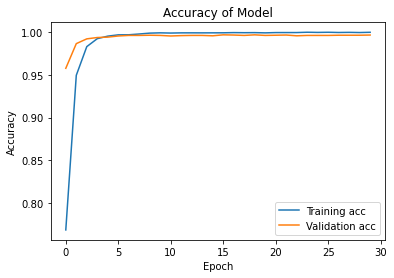

In [22]:
plt.plot(history1.history['accuracy'], label="Training acc")
plt.plot(history1.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

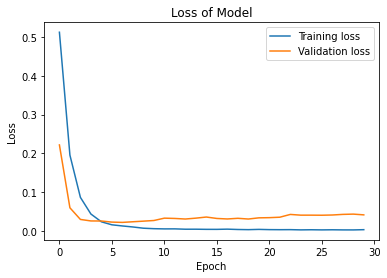

In [23]:
plt.plot(history1.history['loss'], label="Training loss")
plt.plot(history1.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

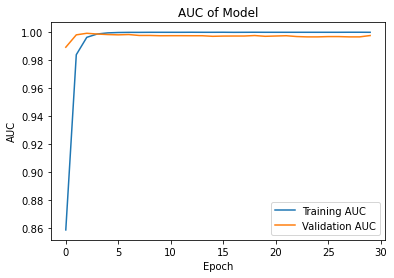

In [24]:
plt.plot(history1.history['auc'], label="Training AUC")
plt.plot(history1.history['val_auc'], label="Validation AUC")
plt.title("AUC of Model")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Final Testing of Unseen Dataset

In [25]:
### 99.6% Accuracy on unseen data
model1.evaluate(test_data)

9/9 [==============================] - 1s 54ms/step - loss: 0.0377 - accuracy: 0.9958 - auc: 0.9973


[0.037736088037490845, 0.9957683682441711, 0.9972518086433411]

### Saving Model

In [26]:
model1.save('encoder_model')

INFO:tensorflow:Assets written to: encoder_model\assets


INFO:tensorflow:Assets written to: encoder_model\assets


### Loading Model

In [27]:
model_load = tf.keras.models.load_model('encoder_model')

### Test Loaded Model

## Prediction Time (Article from Reuters, 2022 June 16)
###  U.S. Senate panel advances public defender vets up for judgeships

https://www.reuters.com/legal/government/us-senate-panel-advances-public-defender-vets-up-judgeships-2022-06-16/


In [29]:
string = "(Reuters) - A US Senate panel on Thursday advanced President Joe Biden's nomination of two women with experience working as public defenders representing indigent defendants to serve as federal appellate judgesThe US Senate Judiciary Committee in separate 12-10 votes cleared the way for the full Senate to consider confirming Lara Montecalvo to serve on the Boston-based 1st US Circuit Court of Appeals and US District Judge Sarah Merriam to join the New York-based 2nd US Circuit Court of AppealsThe panel also advanced two district court picks Tiffany Cartwright a civil rights litigator at MacDonald Hoague & Bayless nominated to the Western District of Washington and Colorado nominee US Magistrate Judge Nina Nin-Yuen WangMontecalvo Merriam and Cartwright each garnered only a single Republican vote in their favor from Senator Lindsey Graham of South Carolina who has often bucked his party to vote for Biden's nomineesMontecalvo and Merriam are among the 26 current or former public defenders whom Biden has nominated to the federal bench according to the progressive group Alliance for Justice Progressive advocates argue that bench has been overly dominated by former prosecutors and former partners at corporate law firmsBiden nominated Merriam last year to her current position as a district court judge in Connecticut and the Senate confirmed her on a 54-46 vote Before becoming a judge she served as a federal public defender in Connecticut from 2007 to 2015She is a judge's judge and she will be an extraordinary addition to the 2nd Circuit said Democratic Senator Richard Blumenthal of Connecticut who recommended herMontecalvo leads the Rhode Island Public Defender's Office which she joined in 2004 Her nomination garnered the support of a broad array of her state's legal and law enforcement establishment including the entire Rhode Island Supreme CourtDuring a May 25 hearing Senator Chuck Grassley of Iowa the panel's ranking Republican questioned Montecalvo about her role in advocating early in the COVID-19 pandemic for the release of inmates to alleviate health risks in the state's prisonsHe asked her about her reasoning for asking the Rhode Island Supreme Court to ease bail requirements for defendants awaiting trial a position the state's court rejected in December 2020 as unnecessaryMontecalvo cited an anticipated winter surge of COVID-19 within the state's prisons as the reason She said she was proud of working with prosecutors earlier in the pandemic to secure the release of 52 people whose sentences were near their end"

In [30]:
### Not bad at detection
model_load.predict(np.array([string]))

1/1 [==============================] - 0s 149ms/step


array([[0.9993911]], dtype=float32)